In [4]:
import torch
import optuna
torch.cuda.is_available()

True

Random Seed:  999


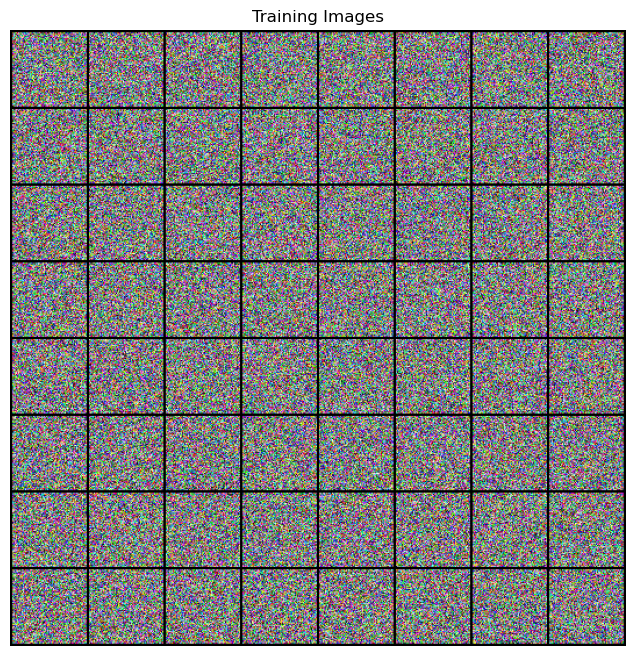

In [82]:
# Derived partially from 
# - https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py
# - https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


# We create a fake image dataset. This ought to be replaced by
# your actual dataset or pytorch's example datasets. We do this here
# to focus more on computation than actual convergence.
class FakeImageDataset(torch.utils.data.Dataset):
    def __init__(self, count=10000):
        self.labels = np.random.randint(0, 10, size=count)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        torch.random.seed = label
        img = torch.rand(3, image_size, image_size)
        return img, label

dataset = FakeImageDataset()

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self, ngpu, leaky_relu_slope=0.2, activation=nn.Sigmoid()):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(leaky_relu_slope, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            activation
        )

    def forward(self, input):
        return self.main(input)
    
    @classmethod
    def from_trial(cls, trial):
        activations = [nn.Sigmoid, nn.Tanh]
        idx = trial.suggest_categorical("descriminator_activation", list(range(len(activations))))
        activation = activations[idx]()
        
        leaky_relu_slope = trial.suggest_float("descriminator_leaky_relu_slope", 0.1, 0.4)
        return cls(ngpu, leaky_relu_slope, activation)
        

def objective(trial):
    ############################
    ### Create the generator ###
    netG = Generator(ngpu).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netG = nn.DataParallel(netG, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    #  to ``mean=0``, ``stdev=0.02``.
    netG.apply(weights_init)

    ################################
    ### Create the Discriminator ###
    netD = Discriminator.from_trial(trial).to(device)

    # Handle multi-GPU if desired
    if (device.type == 'cuda') and (ngpu > 1):
        netD = nn.DataParallel(netD, list(range(ngpu)))

    # Apply the ``weights_init`` function to randomly initialize all weights
    # like this: ``to mean=0, stdev=0.2``.
    netD.apply(weights_init)

    ############################################
    ### Remaining crierion, optimizers, etc. ###
    # Initialize the ``BCELoss`` function
    criterion = nn.BCELoss()

    # Create batch of latent vectors that we will use to visualize
    #  the progression of the generator
    fixed_noise = torch.randn(64, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
    
    # Training Loop

    # Lists to keep track of progress
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(num_epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            
            # Report to Optuna
            trial.report(errG, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1
    return errG

In [83]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1, timeout=600)

[I 2023-04-13 12:16:38,514] A new study created in memory with name: no-name-e1557808-bfea-4edf-b189-310e7c2f96c6


Starting Training Loop...
[0/100][0/79]	Loss_D: 1.7047	Loss_G: 6.1678	D(x): 0.5197	D(G(z)): 0.5568 / 0.0030
[0/100][50/79]	Loss_D: 1.1692	Loss_G: 7.3490	D(x): 0.5440	D(G(z)): 0.3700 / 0.0008
[1/100][0/79]	Loss_D: 1.1556	Loss_G: 3.8444	D(x): 0.4167	D(G(z)): 0.1847 / 0.0231
[1/100][50/79]	Loss_D: 1.5738	Loss_G: 2.5344	D(x): 0.3692	D(G(z)): 0.4115 / 0.0829
[2/100][0/79]	Loss_D: 1.6904	Loss_G: 2.9610	D(x): 0.6335	D(G(z)): 0.7002 / 0.0531
[2/100][50/79]	Loss_D: 1.3962	Loss_G: 1.8337	D(x): 0.5826	D(G(z)): 0.5673 / 0.1628
[3/100][0/79]	Loss_D: 1.4288	Loss_G: 2.1534	D(x): 0.7215	D(G(z)): 0.6625 / 0.1186
[3/100][50/79]	Loss_D: 1.5778	Loss_G: 1.2007	D(x): 0.4548	D(G(z)): 0.5389 / 0.3045
[4/100][0/79]	Loss_D: 1.3355	Loss_G: 0.8772	D(x): 0.3895	D(G(z)): 0.3142 / 0.4184
[4/100][50/79]	Loss_D: 1.3266	Loss_G: 0.9056	D(x): 0.4321	D(G(z)): 0.3772 / 0.4068
[5/100][0/79]	Loss_D: 1.5272	Loss_G: 1.5075	D(x): 0.6133	D(G(z)): 0.6409 / 0.2241
[5/100][50/79]	Loss_D: 1.2432	Loss_G: 1.3182	D(x): 0.5996	D(G(z)): 

[W 2023-04-13 12:17:27,978] Trial 0 failed with parameters: {'descriminator_activation': 0, 'descriminator_leaky_relu_slope': 0.2934874596767668} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/milesg/mambaforge/envs/coiled-benchmarks/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_382623/670346548.py", line 275, in objective
    errG.backward()
  File "/home/milesg/mambaforge/envs/coiled-benchmarks/lib/python3.10/site-packages/torch/_tensor.py", line 487, in backward
    torch.autograd.backward(
  File "/home/milesg/mambaforge/envs/coiled-benchmarks/lib/python3.10/site-packages/torch/autograd/__init__.py", line 200, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt
[W 2023-04-13 12:17:27,979] Trial 0 failed with value None.


KeyboardInterrupt: 